In [218]:
import pandas as pd
import matplotlib.pyplot as plt
import pickle
import numpy as np
from sklearn.preprocessing import StandardScaler, MinMaxScaler, QuantileTransformer
from sklearn.ensemble import HistGradientBoostingRegressor as hgbr
from sklearn.multioutput import MultiOutputRegressor
from sklearn.metrics import r2_score as r2 
import shap, datetime,warnings
warnings.filterwarnings('ignore')

In [219]:
# Open the pickle file
df = pickle.load(open('../../data/processed/merged_data_202507141200.pkl', 'rb'))
df

date ticker  Article Count_cum04_lag01  \
0      2018-01-03 09:45:00    AAL                          4   
1      2018-01-03 09:45:00   ALGT                          0   
2      2018-01-03 09:45:00    ALK                         10   
3      2018-01-03 09:45:00    DAL                          3   
4      2018-01-03 09:45:00   JBLU                          2   
...                    ...    ...                        ...   
337601 2025-05-30 15:45:00    ALK                          0   
337602 2025-05-30 15:45:00    DAL                          3   
337603 2025-05-30 15:45:00   JBLU                          1   
337604 2025-05-30 15:45:00    LUV                          2   
337605 2025-05-30 15:45:00    UAL                          5   

        Article Count_cum16_lag01  Article Count_cum48_lag01  \
0                              25                         80   
1                               0                          2   
2                              24                        185   
3                               7                         24   
4                               9                         17   
...                           ...                        ...   
337601                          3                          9   
337602                         12                         15   
337603                          4                         13   
337604                          3                         11   
337605                         20                         41   

        Article Count_cum96_lag01  Article Count_lag01  Article Count_lag02  \
0                             143                    2                    1   
1                               2                    0                    0   
2                             241                    0                    5   
3                              52                    0                    1   
4                              40                    0                    1   
...                           ...                  ...                  ...   
337601                         31                    0                    0   
337602                         43                    0                    1   
337603                         49                    0                    0   
337604                         30                    1                    1   
337605                        107                    0                    2   

        Article Count_lag04  Article Count_lag16  ...  sentiment_pca_293  \
0                         2                    0  ...          -0.071769   
1                         0                    0  ...          -0.009447   
2                         0                    2  ...           0.404593   
3                         0                    0  ...           0.031247   
4                         0                    0  ...           0.321627   
...                     ...                  ...  ...                ...   
337601                    0                    1  ...           0.069228   
337602                    1                    1  ...          -0.098549   
337603                    0                    0  ...           0.020847   
337604                    0                    0  ...           0.173591   
337605                    0                    0  ...           0.112462   

        sentiment_pca_294  sentiment_pca_295  sentiment_pca_296  \
0                0.092828          -0.337849          -0.188729   
1                0.011431          -0.020614           0.010191   
2               -0.898324           0.201081           0.254234   
3               -0.045478          -0.097993          -0.026443   
4                0.147672          -0.019831          -0.489542   
...                   ...                ...                ...   
337601           0.859418           1.533909           0.130467   
337602           0.869943          -0.262049          -0.578786   
337603           0.

In [220]:
# Data preprocessing
#tickers     = ['AAL','ALGT','ALK','DAL','JBLU','LUV','UAL']
#tickers_all = ['AAL','ALGT','ALK','DAL','JBLU','LUV','UAL','BNO','IYT','ITA','JETS']

y_cols = ['Volume']

#x_cols = [i for i in df.columns if 'lag' in i and all(j not in i for j in ['BNO', 'JETS', 'IYT', 'ITA'])] + [
#'hour_of_day_10','hour_of_day_11','hour_of_day_12','hour_of_day_13','hour_of_day_14','hour_of_day_15','hour_of_day_9','is_close','is_open','month_of_year_1','month_of_year_10',#'month_of_year_11','month_of_year_12','month_of_year_2','month_of_year_3','month_of_year_4','month_of_year_5','month_of_year_6','month_of_year_7','month_of_year_8',#'month_of_year_9'] + [i for i in df.columns if 'pca' in i]

#x_cols = [i for i in df.columns if 'pca' in i] + [i for i in df.columns if any(j in i for j in ['Tone', 'Article Count'])]

#x_cols = [i for i in df.columns if 'lag' in i and all(j not in i for j in ['JETS', 'IYT', 'ITA', 'pca', 'Tone', 'Article Count'])] + [
#'hour_of_day_10','hour_of_day_11','hour_of_day_12','hour_of_day_13','hour_of_day_14','hour_of_day_15','hour_of_day_9','is_close','is_open','month_of_year_1','month_of_year_10',#'month_of_year_11','month_of_year_12','month_of_year_2','month_of_year_3','month_of_year_4','month_of_year_5','month_of_year_6','month_of_year_7','month_of_year_8',#'month_of_year_9']

x_cols = [i for i in df.columns if 'lag' in i] + [
'hour_of_day_10','hour_of_day_11','hour_of_day_12','hour_of_day_13','hour_of_day_14','hour_of_day_15','hour_of_day_9','is_close','is_open','month_of_year_1','month_of_year_10','month_of_year_11','month_of_year_12','month_of_year_2','month_of_year_3','month_of_year_4','month_of_year_5','month_of_year_6','month_of_year_7','month_of_year_8','month_of_year_9'] + [i for i in df.columns if 'pca' in i]

y = df[y_cols]
x = df[x_cols]

In [221]:
# Train/test splitting
split_val  = round(0.8 * len(x))
split_test = round(0.9 * len(x))

x_train = x[:split_val]
x_val   = x[split_val:split_test]
x_test  = x[split_test:]

y_train = y[:split_val]
y_val   = y[split_val:split_test]
y_test  = y[split_test:]

In [222]:
df['date'][:split_val].describe()

count                           270085
mean     2020-12-18 19:55:23.070514176
min                2018-01-03 09:45:00
25%                2019-06-27 12:15:00
50%                2020-12-17 11:30:00
75%                2022-06-10 11:30:00
max                2023-12-04 14:00:00
Name: date, dtype: object

In [223]:
df['date'][split_val:split_test].describe()

count                            33760
mean     2024-04-18 17:51:55.530213120
min                2023-12-04 14:00:00
25%                2024-02-12 10:00:00
50%                2024-04-18 12:30:00
75%                2024-06-25 14:48:45
max                2024-08-30 13:30:00
Name: date, dtype: object

In [224]:
df['date'][split_test:].describe()

count                            33761
mean     2025-01-15 05:11:45.583365120
min                2024-08-30 13:30:00
25%                2024-11-06 09:30:00
50%                2025-01-16 11:00:00
75%                2025-03-25 13:30:00
max                2025-05-30 15:45:00
Name: date, dtype: object

In [225]:
# Normalize the features to [0,1]
sc2 = MinMaxScaler(feature_range=(0, 1))

x_train = sc2.fit_transform(x_train)
x_val   = sc2.transform(x_val)
x_test  = sc2.transform(x_test)

In [226]:
x_train.shape

(270085, 1455)

In [227]:
model = hgbr(
    learning_rate=0.2,
    min_samples_leaf=200,
    l2_regularization=1,
    max_features=1.0,
    max_leaf_nodes=None,
    max_depth=None,
    early_stopping=True,
    scoring='r2',
    n_iter_no_change=10,
    verbose=2,
    max_iter = 1000,
    random_state=42
)

fit = model.fit(x_train, y_train, X_val=x_val, y_val=y_val)

time = datetime.datetime.now().strftime('%Y%m%d%H%M%S')
with open(f'../../output/models/lightgbm_volume_{time}.pkl', 'wb') as f:
    pickle.dump(model, f)

Binning 3.144 GB of training data: 10.024 s
Binning 0.393 GB of validation data: 0.380 s
Fitting gradient boosted rounds:
[1/1000] 1 tree, 621 leaves, max depth = 18, train score: 0.26428, val score: 0.25806, in 3.076s
[2/1000] 1 tree, 649 leaves, max depth = 20, train score: 0.43924, val score: 0.41702, in 3.138s
[3/1000] 1 tree, 688 leaves, max depth = 22, train score: 0.55528, val score: 0.51488, in 3.360s
[4/1000] 1 tree, 712 leaves, max depth = 20, train score: 0.63207, val score: 0.58524, in 3.388s
[5/1000] 1 tree, 744 leaves, max depth = 23, train score: 0.68427, val score: 0.63100, in 3.401s
[6/1000] 1 tree, 759 leaves, max depth = 24, train score: 0.72049, val score: 0.66349, in 3.497s
[7/1000] 1 tree, 795 leaves, max depth = 26, train score: 0.74632, val score: 0.68208, in 3.537s
[8/1000] 1 tree, 809 leaves, max depth = 25, train score: 0.76358, val score: 0.69461, in 3.566s
[9/1000] 1 tree, 841 leaves, max depth = 27, train score: 0.77899, val score: 0.70595, in 3.643s
[10/1

In [228]:
fit.score(x_val, y_val)

0.7336584412545548

In [229]:
fit.score(x_test, y_test)

0.6486932124641043

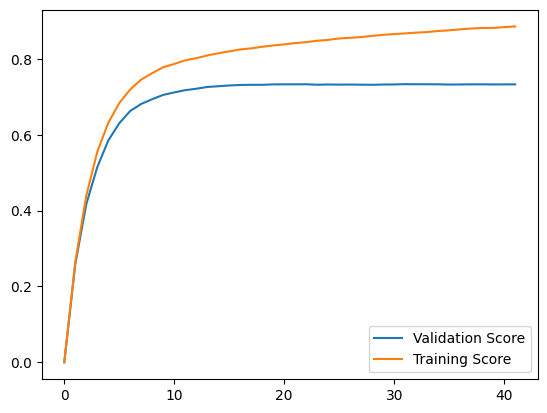

In [230]:
plt.plot(model.validation_score_, label='Validation Score')
plt.plot(model.train_score_, label='Training Score')
plt.legend()

In [231]:
# shap values
# sample 500 values from x_val
x_sample = x_val[np.random.choice(x_val.shape[0], 500, replace=False)]

explainer = shap.TreeExplainer(model, x_sample, feature_names=x_cols)
shap_values = explainer(x_sample, check_additivity=False)

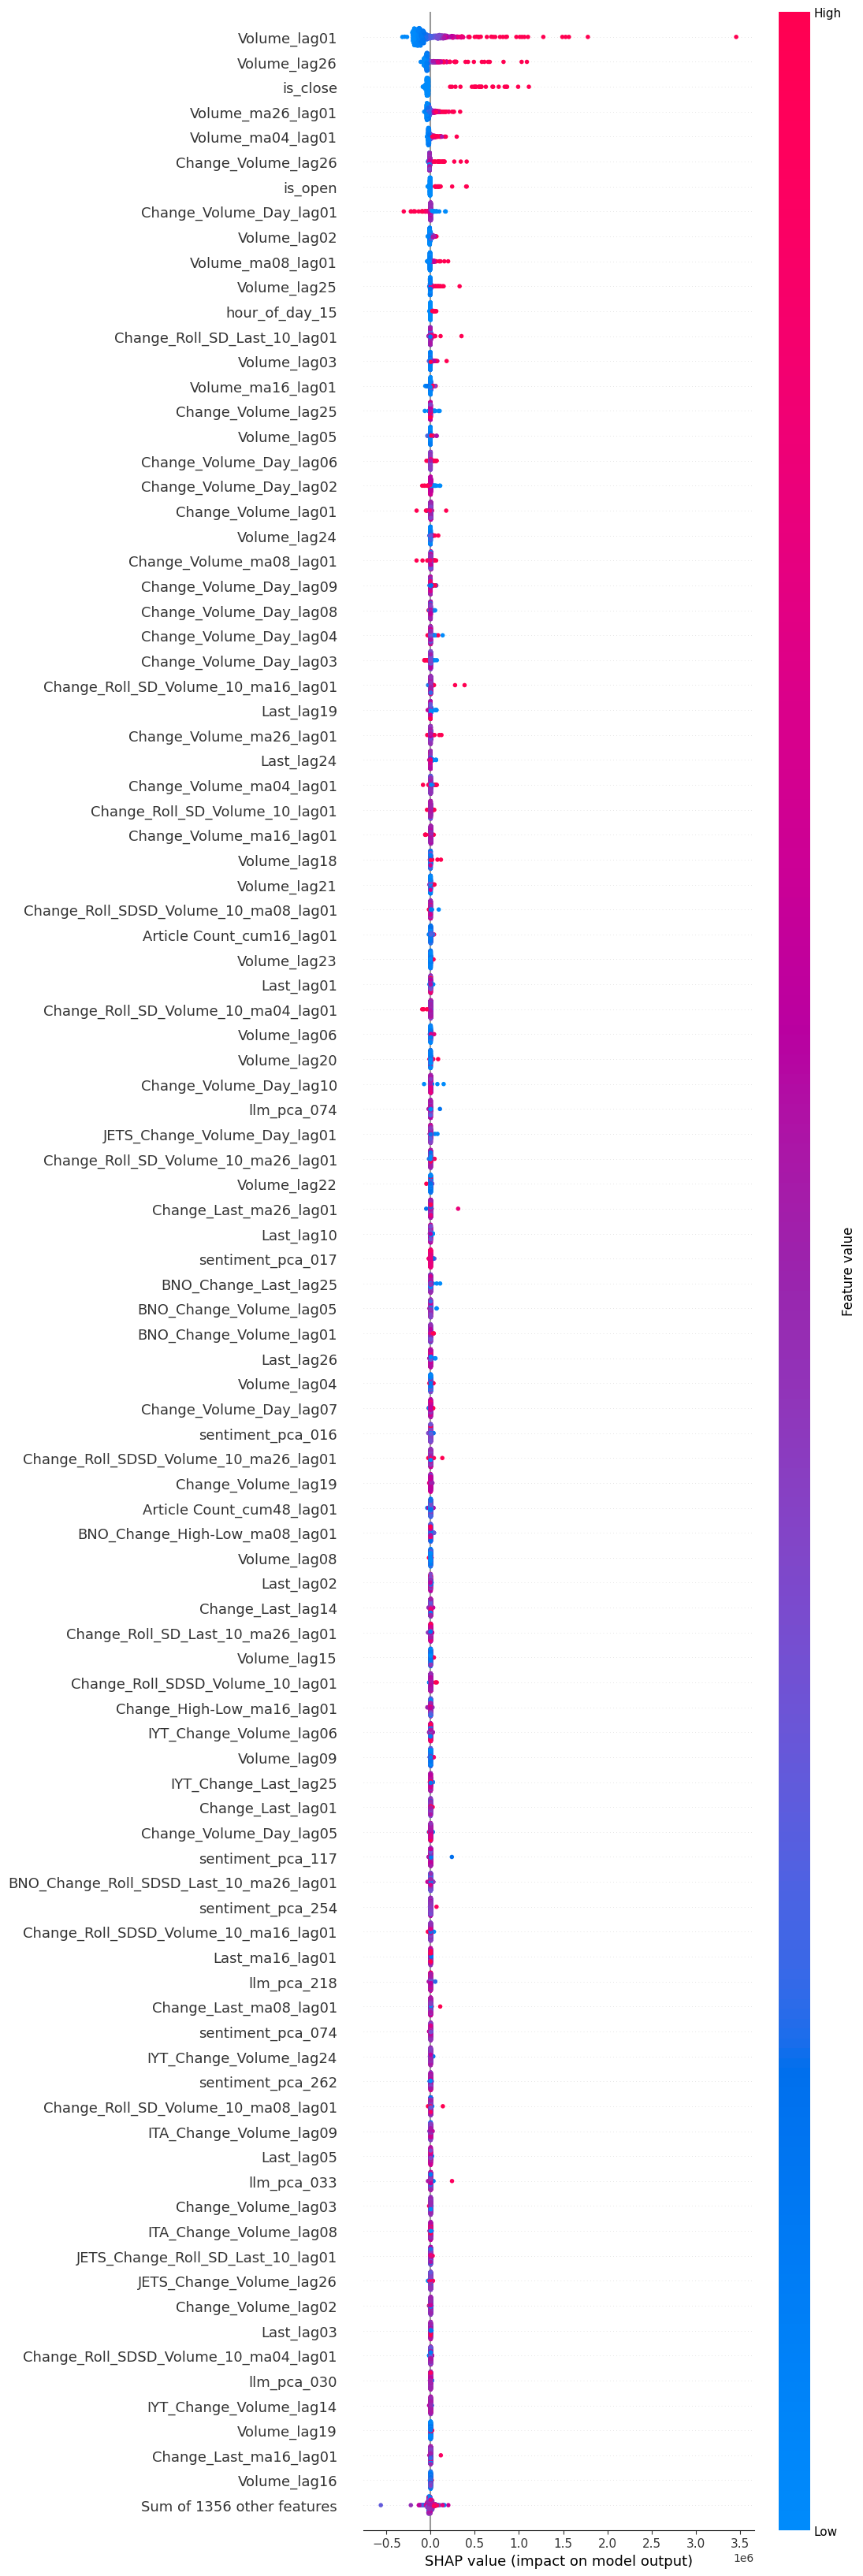

In [232]:
shap.plots.beeswarm(shap_values, max_display=100)

In [160]:
y_pred = model.predict(x_val)
plot_data = y_val.copy()
plot_data['Time'] = plot_data.index
plot_data.reset_index(drop=True, inplace=True)

In [235]:
y_pred = model.predict(x_val)
y_pred = np.where(y_pred < 0, 0, y_pred)  # Ensure no negative predictions
y_pred = pd.Series(y_pred, index=y_val.index)

In [236]:
df_results = df.copy()
df_results = df_results.iloc[y_val.index,:]
df_results['y_pred'] = y_pred
df_results['residuals'] = df_results['Volume'] - df_results['y_pred']
df_results

date ticker  Article Count_cum04_lag01  \
270085 2023-12-04 14:00:00    ALK                         18   
270086 2023-12-04 14:00:00    DAL                          2   
270087 2023-12-04 14:00:00   JBLU                          7   
270088 2023-12-04 14:00:00    LUV                          2   
270089 2023-12-04 14:00:00    UAL                          2   
...                    ...    ...                        ...   
303840 2024-08-30 13:30:00   ALGT                          0   
303841 2024-08-30 13:30:00    ALK                          2   
303842 2024-08-30 13:30:00    DAL                          1   
303843 2024-08-30 13:30:00   JBLU                          5   
303844 2024-08-30 13:30:00    LUV                          3   

        Article Count_cum16_lag01  Article Count_cum48_lag01  \
270085                         77                        173   
270086                         13                         29   
270087                         31                         79   
270088                         14                         30   
270089                         12                         33   
...                           ...                        ...   
303840                          0                          1   
303841                          6                         22   
303842                          7                         11   
303843                         16                         36   
303844                         14                         20   

        Article Count_cum96_lag01  Article Count_lag01  Article Count_lag02  \
270085                        641                    3                   10   
270086                         64                    1                    0   
270087                        415                    2                    2   
270088                         60                    1                    1   
270089                         79                    1                    0   
...                           ...                  ...                  ...   
303840                          2                    0                    0   
303841                         74                    1                    1   
303842                         50                    1                    0   
303843                         85                    2                    2   
303844                         38                    1                    2   

        Article Count_lag04  Article Count_lag16  ...  sentiment_pca_295  \
270085                    3                    5  ...           0.565441   
270086                    1                    1  ...          -0.036747   
270087                    2                    1  ...          -0.056143   
270088                    0                    1  ...           0.075383   
270089                    1                    1  ...          -0.030756   
...                     ...                  ...  ...                ...   
303840                    0                    0  ...          -0.029826   
303841                    0                    0  ...           0.032163   
303842                    0                    0  ...          -0.294496   
303843                    0                    0  ...           0.127846   
303844                    0                    0  ...          -0.066449   

        sentiment_pca_296  sentiment_pca_297  sentiment_pca_298  \
270085          -0.304639          -0.546424           0.632031   
270086           0.025630           0.284650          -0.014649   
270087           0.425695           0.169083           0.239773   
270088           0.127710           0.428332          -0.095260   
270089           0.309050           0.646624          -0.592963   
...                   ...                ...                ...   
303840           0.018689           0.026539          -0.008435   
303841          -0.034872          -0.086550           0.020872   
303842           0.

In [237]:
for i in df['ticker'].unique():
    vals = df.iloc[y_val.index,:][df['ticker'] == i].index
    print(f'{i}: {r2(y_val[y_val.index.isin(vals)], y_pred[y_pred.index.isin(vals)]):.3f}')

AAL: 0.626
ALGT: 0.458
ALK: 0.650
DAL: 0.693
JBLU: 0.587
LUV: 0.529
UAL: 0.744


In [238]:
df['time_of_day'] = df['date'].dt.time

for i in np.sort(df['time_of_day'].unique()):
    vals = df.iloc[y_val.index,:][df['time_of_day'] == i].index
    print(f'{i}: {r2(y_val[y_val.index.isin(vals)], y_pred[y_pred.index.isin(vals)]):.3f}')

09:30:00: 0.307
09:45:00: 0.655
10:00:00: 0.797
10:15:00: 0.828
10:30:00: 0.857
10:45:00: 0.724
11:00:00: 0.778
11:15:00: 0.759
11:30:00: 0.821
11:45:00: 0.739
12:00:00: 0.808
12:15:00: 0.777
12:30:00: 0.736
12:45:00: 0.417
13:00:00: 0.617
13:15:00: 0.838
13:30:00: 0.816
13:45:00: 0.730
14:00:00: 0.731
14:15:00: 0.774
14:30:00: 0.743
14:45:00: 0.816
15:00:00: 0.726
15:15:00: 0.756
15:30:00: 0.767
15:45:00: 0.767


In [195]:
df['day_of_week'] = df['date'].dt.day_of_week

for i in np.sort(df['day_of_week'].unique()):
    vals = df.iloc[y_val.index,:][df['day_of_week'] == i].index
    print(f'{i}: {r2(y_val[y_val.index.isin(vals)], y_pred[y_pred.index.isin(vals)]):.3f}')

0: 0.733
1: 0.729
2: 0.728
3: 0.774
4: 0.761


In [200]:
df['month_of_year'] = df['date'].dt.month

for i in np.sort(df['month_of_year'].unique()):
    try:
        vals = df.iloc[y_val.index,:][df['month_of_year'] == i].index
        print(f'{i}: {r2(y_val[y_val.index.isin(vals)], y_pred[y_pred.index.isin(vals)]):.3f}')
    except Exception:
        pass

1: 0.727
2: 0.822
3: 0.745
4: 0.804
5: 0.692
6: 0.719
7: 0.754
8: 0.700
12: 0.804


In [188]:
np.sort(df['time_of_day'].unique())

array([datetime.time(9, 30), datetime.time(9, 45), datetime.time(10, 0),
       datetime.time(10, 15), datetime.time(10, 30),
       datetime.time(10, 45), datetime.time(11, 0), datetime.time(11, 15),
       datetime.time(11, 30), datetime.time(11, 45), datetime.time(12, 0),
       datetime.time(12, 15), datetime.time(12, 30),
       datetime.time(12, 45), datetime.time(13, 0), datetime.time(13, 15),
       datetime.time(13, 30), datetime.time(13, 45), datetime.time(14, 0),
       datetime.time(14, 15), datetime.time(14, 30),
       datetime.time(14, 45), datetime.time(15, 0), datetime.time(15, 15),
       datetime.time(15, 30), datetime.time(15, 45)], dtype=object)

In [137]:
plot_data = pd.merge(plot_data, pd.DataFrame(y_pred, columns=['y_pred']), left_index=True, right_index=True)

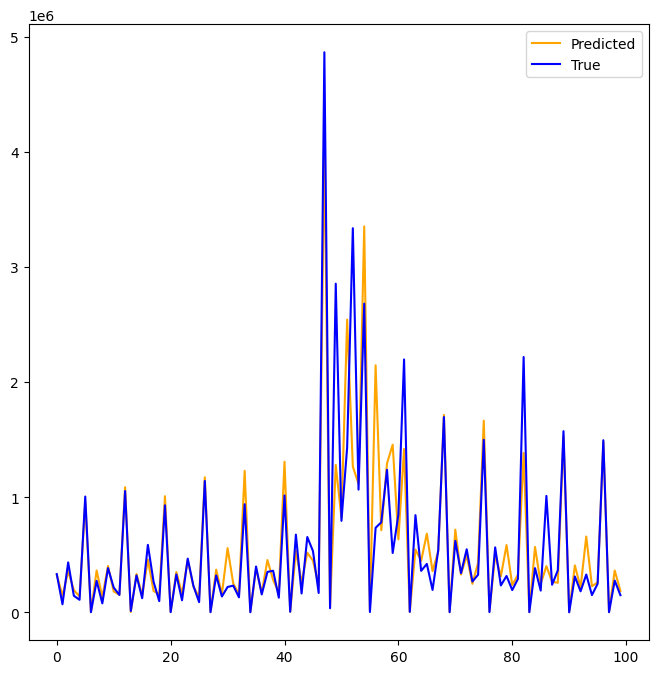

In [138]:
filter_data = plot_data.iloc[:100,:]

plt.figure(figsize=(8, 8))
plt.plot(filter_data.index, filter_data['y_pred'], label='Predicted', color='orange')
plt.plot(filter_data.index, filter_data['Volume'], label='True', color='blue')
plt.legend()

C:\Users\Steven\AppData\Local\Temp\ipykernel_1220\2646763451.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filter_data['residuals'] = filter_data['AAL_Volume'] - filter_data['y_pred']


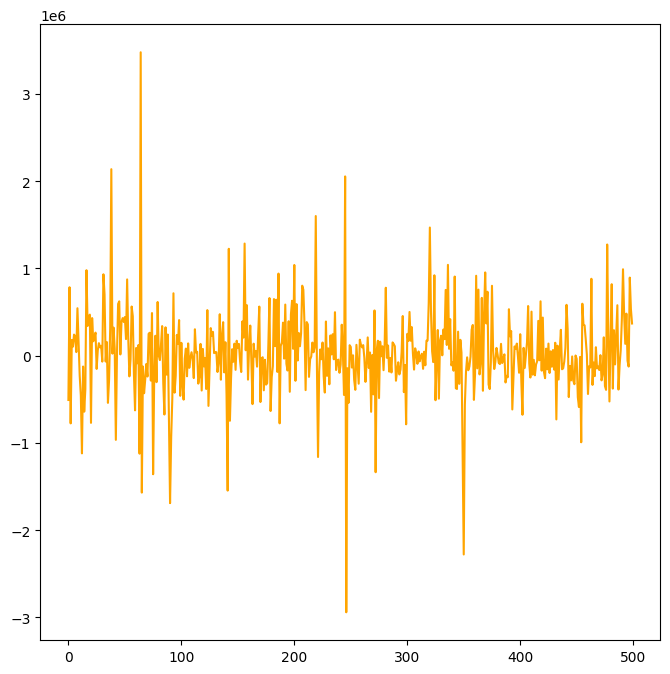

In [165]:
filter_data = plot_data.iloc[:500,:]
filter_data['residuals'] = filter_data['AAL_Volume'] - filter_data['y_pred']

plt.figure(figsize=(8, 8))
plt.plot(filter_data.index, filter_data['residuals'], label='residuals', color='orange')